# Face2Imogi 만들기

## 1. 데이터 가져오기

In [1]:
import numpy as np
import tqdm
import os

train_x = []
train_y = []
eval_x = []
eval_y = []

csv_path = os.getenv('HOME')+'/aiffel/tfjs_mobile/data/fer2013.csv'

with open(csv_path) as f:
  for line in tqdm.tqdm(f.read().splitlines()[1:]):
    emotion, pixels, usage = line.split(',')
    
    x = np.array(pixels.split(' ')).astype(float).reshape(48, 48, 1) / 255
    y = int(emotion)

    if usage == 'PrivateTest':
      eval_x.append(x)
      eval_y.append(y)
    else:
      train_x.append(x)
      train_y.append(y)

print('train : {}, eval :{}'.format(len(train_x), len(eval_x)))

100%|██████████| 35887/35887 [00:26<00:00, 1349.98it/s]

train : 32298, eval :3589


Angry


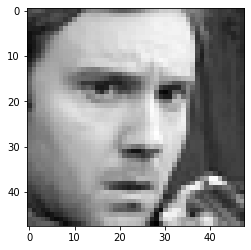

In [2]:
from matplotlib import pyplot as plt

LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

print(LABELS[train_y[0]])
plt.imshow(train_x[0].reshape([48, 48]), cmap='gray')

## 2. MobileNet으로 학습시키기

In [3]:

import tensorflow as tf

# model 선언 
model = tf.keras.applications.MobileNetV2(input_shape=(48, 48, 1), weights=None, classes=7)

# model.compile
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

#model.fit
model.fit(np.stack(train_x),
          tf.keras.utils.to_categorical(train_y),
          epochs=100,
          batch_size=512,
          validation_data=(np.stack(eval_x),
                           tf.keras.utils.to_categorical(eval_y)))

Epoch 1/100
64/64 [==============================] - 72s 1s/step - loss: 1.8259 - categorical_accuracy: 0.2532 - val_loss: 1.9330 - val_categorical_accuracy: 0.2449
Epoch 2/100
64/64 [==============================] - 6s 93ms/step - loss: 1.6757 - categorical_accuracy: 0.3316 - val_loss: 1.9239 - val_categorical_accuracy: 0.2449
Epoch 3/100
64/64 [==============================] - 6s 92ms/step - loss: 1.5477 - categorical_accuracy: 0.3973 - val_loss: 1.9218 - val_categorical_accuracy: 0.1471
Epoch 4/100
64/64 [==============================] - 6s 93ms/step - loss: 1.4691 - categorical_accuracy: 0.4327 - val_loss: 1.9191 - val_categorical_accuracy: 0.1471
Epoch 5/100
64/64 [==============================] - 6s 93ms/step - loss: 1.3899 - categorical_accuracy: 0.4691 - val_loss: 1.9211 - val_categorical_accuracy: 0.1471
Epoch 6/100
64/64 [==============================] - 6s 93ms/step - loss: 1.3390 - categorical_accuracy: 0.4872 - val_loss: 1.9201 - val_categorical_accuracy: 0.1744
Epoch

## 3. 저장하기

In [4]:
import os
model_path = os.getenv('HOME')+'/aiffel/tfjs_mobile/model.h5'
model.save(model_path)

## 4. index.html 만들고 Github에 올리기

<html>
  <head>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, user-scalable=yes, initial-scale=1, maximum-scale=1">
    <title>Demo</title>
    <script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@1.0.1"></script>
  </head>
  <body>
    <video playsinline autoplay></video>
    <button>Capture</button>
    <canvas></canvas>
    <span></span>
    <script>
      video = document.querySelector('video');
      canvas = document.querySelector('canvas');
      button = document.querySelector('button');
      canvas.width = 48;
      canvas.height = 48;
      canvas.style.filter = 'grayscale(1)';
      video.style.transform = 'scaleX(-1)';

      span = document.querySelector('span');
      span.style.fontSize = '48px';


      const LABELS = {
        0: '🤬', // angry
        1: '🤢', // disgust
        2: '😱', // fear
        3: '😄', // happy
        4: '😢', // sad
        5: '😲', // surprise
        6: '😐' // neutral
      }
      
      function classifyCallback(predictions) {
        alert(predictions[0].className + ':' + predictions[0].probabaility);
      }

      async function predict() {
        const model = await tf.loadLayersModel('./model/model.json');

        image = tf.browser.fromPixels(canvas);
        console.log(image);
        image = image.toFloat().mean(2).mul(1/255.0).reshape([-1, 48, 48, 1]);
        logits = model.predict(image);
        const results = await logits.softmax().data();
        i = results.indexOf(Math.max(...results));

        image.dispose();
        logits.dispose();
        console.log(results);
        
        span.innerHTML = LABELS[i];
      }

      button.onclick = function() {
        w = video.videoWidth;
        h = video.videoHeight;
        s = Math.min(w, h);
        sx = (w-s)/2;
        sy = (h-s)/2;

        canvas.getContext('2d').drawImage(video, sx=sx, sy=sy, swidth=s,
          sheight=s, x=0, y=0, width=48, height=48);

        span.innerHTML = '⌛';
        predict();
    };


    constraints = {
      audio: false,
      video: true
    };

    function handleSuccess(stream) {
      video.srcObject = stream;
    }

    function handleError(error) {
      alert('navigator.MediaDevices.getUserMedia error: ' + error.message + error.name);
    }

    navigator.mediaDevices.getUserMedia(constraints).then(handleSuccess).catch(handleError);
    </script>
</body>

</html>


## 5. 완성품

https://mezcalagave.github.io/tfjs_mobile/

## 6. 개선할 수 있는 점

1. 과거에 배웠던 face recognition을 이용하는 방법도 하나일 것이다.    
2. transfer learning이 가능했다면 더 좋았을 수도 있다.    
3. 데이터가 많으면 더 정확해질 가능성이 있다.    


## 7. 느낀점

우선적으로 처음 javascript와 html을 전문적으로 쓰다 보니 이번 노드를 하는데 애를 먹었다. 그러나 모바일로 딥러닝을 구현해냈다는 점에서 매우 신기했다.     
그러나 모바일에서 구현한다는 것 자체가 아무래도 한계점은 노출시키고 있다고 생각한다. 혹자는 딥러닝이 발전한 이유는 여러 학자들의 공헌이라고 얘기하기보다 GPU라는 하드웨어의 발달에 맞춰 진화한 것이라고 이야기한다.    이에 대해 어느정도 동의한다. 그러나 인간이 AI를 더 경량화하여 어디에든 장착할 수 있다고 가정하면 많은 활용성을 가져다 줄 것이다.